## Part 2: Clinical Application

Using the CAST dataset, investigate the trend that average resting ehart rate increase up until middle age then decrease into old age.

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

In [3]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [4]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [5]:
metadata_filename = '/data/crisdb/metadata.csv'

with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

In [6]:
metadata.head(5)

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [19]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = filename.rsplit('/')[-1].rstrip('.npz')

    # Find the age group for this subject in metadata.
    age_group = metadata.loc[metadata['subject'] == subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata.loc[metadata['subject'] == subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [20]:
df.head(5)

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. More about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

In [ ]:
# !pip install seaborn==0.9.0

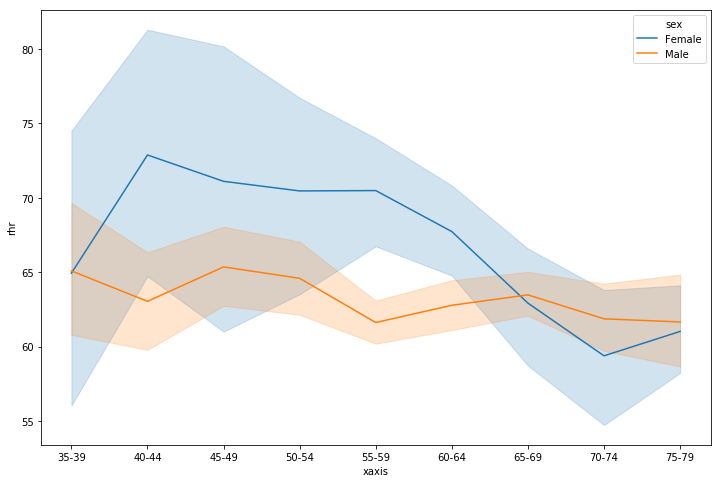

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion

For females, we see a notable increase in resting heart rate from ages 35-39 to age 40-44, then a slight decline from 40-44 to 55-59 before a steeper decline from 55-59 to ages higher than 70. We also see a larger confidence interval from ages 40-44 to 55-59, indicating that female resting heart ranges could easily be around 10 RHR higher or lower than average.

For males, we see a minor increase in heart rate around age 45-49, and then slight decline into old age.

Compared to males, females have a higher average resting heart rate from ages 40-44 to 65-69. Additionally, females have a much wider confidence interval around their average heart rate values compared to men. The trend of increasing heart rate into middle age before decreasing heart rate into old age is much more visible in women.

There may be several possible reasons these results. First, women are generally expected to have a higher heart rate than men because females hearts are typically smaller than male hearts and must beat faster to provide similar output of blood per beat. Women also have a slightly faster physiological heart rhythm, causing higher heart rates ([journal source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4190707/)). Menopausal women may also experience changes in heart rate. 

It is important to verify that the dataset is representative of the broader population for both men and women. As shown in the bar charts below, females are clearly underrepresented compared to males in the CAST dataset. This could likely be the reason why the confidence interval for women is much wider then it is for men. Additionally, the age distributions for both men and women are both left skewed with most samples taken around middle age (50s to 60s), while younger age groups are underrepresented. This could be expected because the CAST dataset is collected from people who have had a myocardial infarction (MI) within the past two years, which are more common in middle and older aged people. We might improve our results if we chose a larger dataset that is more representative of the broader population age and sex demographics, and compared equal counts of males and females.

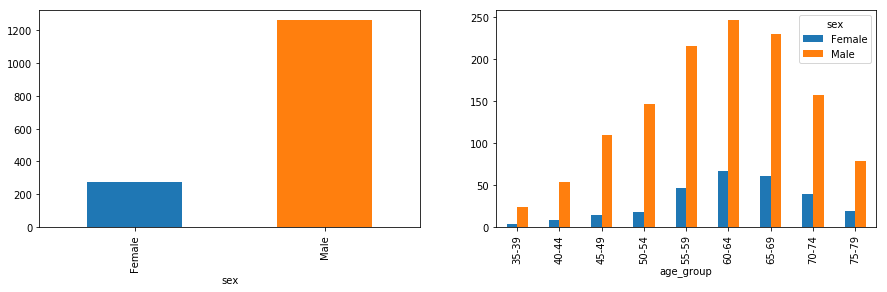

In [16]:
figure, axes = plt.subplots(1, 2, figsize=(15,4))

df.groupby('sex').size().plot(kind='bar', ax=axes[0])
df.groupby(['age_group', 'sex']).size().unstack(level=1).plot(kind='bar', ax=axes[1])

We were unable to fully validate for both sexes the trend that average resting heart rate increases up until middle age and then decreases into old age. Our dataset did not contain adequate samples for younger ages, so we did not see an increase in heart rate for men although we did see an increase for women between age groups 35-39 and 40-44. For both sexes, we were able to see in the plots that average resting heart rate decreases from middle age into old age. However, the age and sex demographics of the CAST dataset are not sufficient to fully validate the trend.